## Deploy a trained Model
모델을 재학습하는 대신, 이전에 학습된 모델을 로드하여 재사용합니다.

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

SageMaker Estimator 인스턴스를 생성하고 `estimator.attach()`로 학습한 모델을 쉽게 불러올 수 있습니다.

In [2]:
from sagemaker.tensorflow import TensorFlow
estimator = TensorFlow(base_job_name='cifar10',
                       entry_point='cifar10_keras_sm_tf2.py', # 여러분이 작성한 엔트리포인트 파일명으로 변경해 주세요
                       source_dir='training_script',
                       role=role,
                       framework_version='2.0.0', # TensorFlow 버전을 지정합니다.
                       py_version='py3',
                       script_mode=True,                       
                       hyperparameters={'epochs': 5},
                       train_instance_count=1, 
                       train_instance_type='ml.p2.xlarge')

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


SageMaker 콘솔 좌측 메뉴에서 `Training` > `Training jobs`를 클릭하여 이전 단계에서 수행했던 training_job_name을 그대로 가져옵니다.

참고로, 콘솔 접속 없이 주피터 노트북에서 아래 CLI 커맨드로 training job 목록들을 쉽게 확인할 수 있습니다.
```shell
!aws sagemaker list-training-jobs
```

In [3]:
%store -r train_job_name

In [4]:
#estimator = estimator.attach(training_job_name=)  ## Configure with your previous cifar10 job name
estimator = estimator.attach(training_job_name=train_job_name)  ## Configure with your previous cifar10 job name


2021-01-26 09:47:03 Starting - Preparing the instances for training
2021-01-26 09:47:03 Downloading - Downloading input data
2021-01-26 09:47:03 Training - Training image download completed. Training in progress.
2021-01-26 09:47:03 Uploading - Uploading generated training model
2021-01-26 09:47:03 Completed - Training job completed


아래 코드 셀을 통해 SageMaker 엔드포인트(endpoint)를 생성합니다. 배포 인스턴스를 시작하기 때문에 약 7분에서 10분의 시간이 소요됩니다. 

In [5]:
%%time
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!CPU times: user 230 ms, sys: 20.3 ms, total: 251 ms
Wall time: 6min 31s


## Make some predictions

엔드포인트(endpoint)가 정상적으로 작동하는지 검증하기 위해, 여러분께서는 랜덤 데이터를 생성하여 예측(prediction)을 수행합니다.

In [6]:
# Creating fake prediction data
import numpy as np
data = np.random.randn(1, 32, 32, 3)
print("Predicted class is {}".format(np.argmax(predictor.predict(data)['predictions'])))

Predicted class is 2


file_name:  data/test/test_batch

Example of Image 30:
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


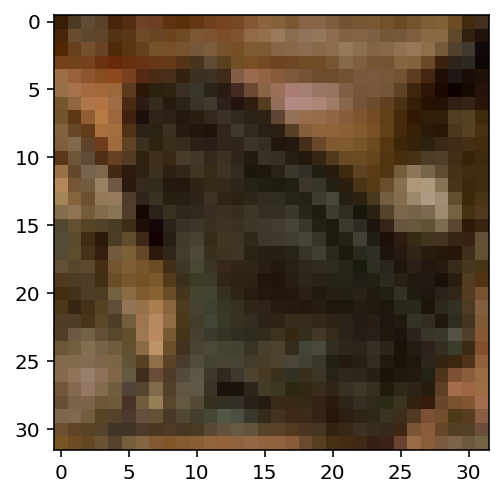

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import utils.p_utils 
from importlib import reload

utils.p_utils = reload(utils.p_utils)
from utils.p_utils import load_cfar10_batch, display_img

cifar10_dataset_file_path ='data/test/test_batch'
features, labels = load_cfar10_batch(cifar10_dataset_file_path)        

sample_id = 30
feature, label = display_img(features,labels, sample_id )



In [18]:
import numpy as np

r_feature = feature[np.newaxis, :, :, :]
r_feature.shape

(1, 32, 32, 3)

In [19]:
pred_response = predictor.predict(r_feature)
print(pred_response)
print("Predicted class is {}".format(np.argmax(pred_response['predictions'])))

{'predictions': [[1.2085643e-05, 4.78853099e-06, 0.0331644267, 0.0131974407, 0.0229037367, 0.00118809077, 0.929396808, 0.000126925806, 9.87623707e-07, 4.65578e-06]]}
Predicted class is 6


# Cleaning up
본 워크샵에서 사용한 리소스에 대해 여러분의 AWS 계정에 과금되지 않도록 하려면 SageMaker Endpoint를 삭제해야 합니다.

In [ ]:
sagemaker_session.delete_endpoint(predictor.endpoint)